<a href="https://colab.research.google.com/github/namanphy/END2/blob/main/S3/Addition_in_NN_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(1)

# Setting up the data
-----

## **Data Modelling**

The MNIST data consists of `28x28` tensors of  images of hand-written digits and a corresponding ground truth value representing the number (`0 to 9`) of the image.

The given problem demands to create a custom dataset.

For this refer to [github readme](https://github.com/namanphy/END2/blob/main/S3/readme.md)


In [88]:
class mnist_sum_dataset(Dataset):
    def __init__(self, train=True):
        self.train = train
        self.train_set_mnist = datasets.MNIST('../data', 
                                        train=train, 
                                        download=True,
                                        transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.1307,), (0.3081,))
                                        ]))


        self.test_set_mnist = datasets.MNIST('../data', 
                                        train=train, 
                                        download=True,
                                        transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.1307,), (0.3081,))                       
                                        ]))

        if train:
            # generating random number and one-hot vector for the number
            _random_int_list_train = [np.random.randint(0,10) for i in range(len(self.train_set_mnist))]
            self.number_embedding_train = np.identity(10)[_random_int_list_train]

            # Summing the image labels and random number for final label
            self.sum_list_train = list(map(lambda x,y: x[1] + y, self.train_set_mnist, _random_int_list_train))
        else:
            # generating random number and one-hot vector for the number
            _random_int_list_test = [np.random.randint(0,10) for i in range(len(self.test_set_mnist))]
            self.number_embedding_test = np.identity(10)[_random_int_list_test]

            # Summing the image labels and random number for final label
            self.sum_list_test = list(map(lambda x,y: x[1] + y, self.test_set_mnist, _random_int_list_test))

    def __getitem__(self, index):
        # mnist_number = self.train_set_mnist[index][1]
        if self.train:
            image = self.train_set_mnist[index][0]
            number_embed = torch.as_tensor(self.number_embedding_train[index], dtype=torch.float32)  # converting to tensor
            label = torch.tensor(self.sum_list_train[index])
        else:
            image = self.test_set_mnist[index][0]
            number_embed = torch.as_tensor(self.number_embedding_test[index], dtype=torch.float32)  # converting to tensor
            label = torch.tensor(self.sum_list_test[index])
        return ([image, number_embed], label)

    def __len__(self):
        return len(self.sum_list_train) if self.train else len(self.sum_list_test)


In [89]:
# Making train and test datasets from our custom_class

train_set = mnist_sum_dataset(train=True)
test_set = mnist_sum_dataset(train=False)

### Seeing what's inside our custom dataset

In [90]:
# Finding what the first index is about

print('Image shape: ', train_set[0][0][0].shape, '\nRandom Number: ', train_set[0][0][1], '\nLabel: ', train_set[0][1])

Image shape:  torch.Size([1, 28, 28]) 
Random Number:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]) 
Label:  tensor(7)


In [91]:
print(train_set[0][0][1].shape)
print(train_set[0][1].shape)

print(train_set[0][0][0].requires_grad)
print(train_set[0][0][1].requires_grad)
print(train_set[0][1].requires_grad)

torch.Size([10])
torch.Size([])
False
False
False


In [92]:
# Length of the train dataset
len(train_set)

60000

## **Visualising our Data**

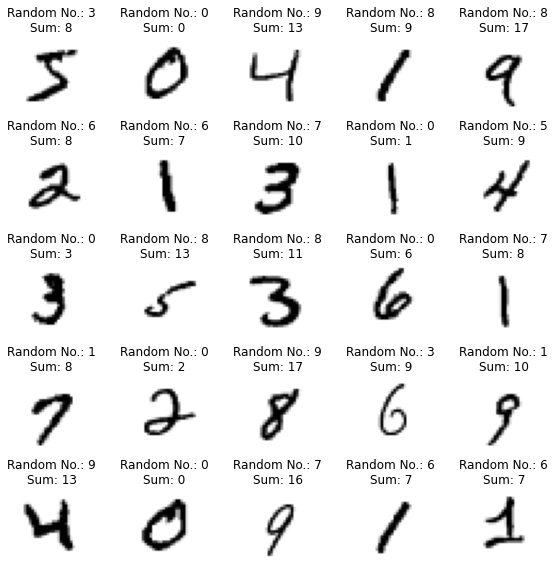

In [18]:
data = list()
for i in range(25):
    # print(obj[0][1])
    data.append({
        'image': train_set[i][0][0],
        # 'img_label': obj[0][1],
        'rand_int': np.where(train_set[i][0][1] == 1)[0].item(),
        'sum': train_set[i][1]
    })


def plot_results(data):
    """
    @var data: dict('image', 'image_label', 'rand_int', 'sum')
    """

    # Initialize plot
    row_count = -1
    fig, axs = plt.subplots(5, 5, figsize=(8, 8))
    fig.tight_layout()

    for idx, result in enumerate(data):
        if idx > 24:
            break
        
        # img_label = result['image_label'].item()
        rand_int = result['rand_int']
        sum = result['sum']

        # Plot image
        if idx % 5 == 0:
            row_count += 1
        axs[row_count][idx % 5].axis('off')
        axs[row_count][idx % 5].set_title(f'Random No.: {rand_int}\nSum: {sum}')
        axs[row_count][idx % 5].imshow(result['image'].squeeze(), cmap='gray_r')

plot_results(data)

## **DataLoaders**

In [93]:
BS = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(train_set , batch_size=BS , shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(train_set , batch_size=BS , shuffle=True, **kwargs)

# Model Preparation

In [74]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), # RF - 3x3
            nn.ReLU(), # RF - 3x3
            nn.BatchNorm2d(16), # RF - 3x3
            nn.Conv2d(16, 16, 3), # RF - 5x5
            nn.ReLU(), # RF - 5x5
            nn.BatchNorm2d(16), # RF - 5x5
            nn.MaxPool2d(2, 2) # RF - 10x10
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), # RF - 12x12
            nn.ReLU(), # RF - 12x12
            nn.BatchNorm2d(32), # RF - 12x12
            nn.Conv2d(32, 32, 3), # RF - 14x14
            nn.ReLU(), # RF - 14x14
            nn.BatchNorm2d(32), # RF - 14x14
            nn.MaxPool2d(2, 2) # RF - 28x28
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 10, 3) # RF - 30x30
        )

        self.linear1 = nn.Linear(20, 40)
        self.linear2 = nn.Linear(40, 80)
        self.linear3 = nn.Linear(80, 19)

    def forward(self, image, number):
        x = self.conv1(image)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.mean(dim=[-2,-1])  # Global Average Pooling
        x = x.view(-1, 10)

        # print(x.shape, number.shape)
        # print(number)
        X = torch.cat((x, number), 1)

        # print(X.shape)
        # print(X)
        X = self.linear1(X)
        X = self.linear2(X)
        X = self.linear3(X)
        X = X.view(-1, 19)

        return F.log_softmax(X)

### Making a dry run - Model

In [75]:
model = Net().to(device)
model.forward(torch.rand((1, 1, 28, 28)).to(device), torch.rand((1, 10)).to(device))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-2.7204, -3.1945, -3.0271, -2.9948, -2.9299, -2.9844, -2.9893, -3.0298,
         -2.8632, -2.7881, -2.8203, -2.8137, -3.0214, -2.9356, -2.9942, -2.7515,
         -3.1685, -2.9797, -3.0960]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)

# Training 

In [80]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    print(f"EPOCH - {epoch}")
    model.train()
    pbar = tqdm(train_loader, position=0, leave=True)
    for batch_idx, (data, target) in enumerate(pbar):
        image, number, target = data[0].to(device), data[1].to(device), target.to(device)
        optimizer.zero_grad()
        output = model(image, number)  # Passing batch

        loss = F.nll_loss(output, target)  # Calculate Loss

        # Gradient calculation and weight update
        loss.backward()
        optimizer.step()

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            image, number, target = data[0].to(device), data[1].to(device), target.to(device)
            output = model(image, number)

            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [95]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH - 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.6276, Accuracy: 22391/60000 (37%)

EPOCH - 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.4246, Accuracy: 25142/60000 (42%)

EPOCH - 3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.1148, Accuracy: 34062/60000 (57%)

EPOCH - 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0182, Accuracy: 37585/60000 (63%)

EPOCH - 5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9370, Accuracy: 39153/60000 (65%)

EPOCH - 6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9254, Accuracy: 38782/60000 (65%)

EPOCH - 7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.8140, Accuracy: 41659/60000 (69%)

EPOCH - 8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.8951, Accuracy: 38638/60000 (64%)

EPOCH - 9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7991, Accuracy: 41775/60000 (70%)

EPOCH - 10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7397, Accuracy: 43540/60000 (73%)

EPOCH - 11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7065, Accuracy: 43493/60000 (72%)

EPOCH - 12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7108, Accuracy: 44184/60000 (74%)

EPOCH - 13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6876, Accuracy: 45802/60000 (76%)

EPOCH - 14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7179, Accuracy: 43093/60000 (72%)

EPOCH - 15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7135, Accuracy: 42738/60000 (71%)

EPOCH - 16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6581, Accuracy: 45259/60000 (75%)

EPOCH - 17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7021, Accuracy: 43845/60000 (73%)

EPOCH - 18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5990, Accuracy: 47548/60000 (79%)

EPOCH - 19


loss=0.7975055575370789 batch_id=468: 100%|██████████| 469/469 [00:13<00:00, 35.46it/s]



Test set: Average loss: 0.6199, Accuracy: 45967/60000 (77%)

